# PyTorch Neural Net

In [1]:
import os
from glob import glob
import random
import time
import pickle
import torch

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore')
%matplotlib inline
from IPython.display import display, Image
import matplotlib.image as mpimg
import cv2

from sklearn.model_selection import train_test_split
from sklearn.metrics import log_loss

#to import from src directory
import sys
sys.path.append('./src/')

%load_ext autoreload
%autoreload 1
%aimport main
%aimport Helper

In [2]:
# some constants

#random numbers rn
NUM_TRAIN = 9000
NUM_VAL = 1000
NUM_TEST = 10000

NUM_CLASSES = 10
IMG_W = 64
IMG_H = 64

RS = 22 # random seed

In [3]:
%autoreload

# FOR LOADING THE DATA FOR THE FIRST TIME
# COMMENT OUT ONCE PICKLE FILES ARE SAVED

#Xtrain, Ytrain = Helper.load_train(IMG_W, IMG_H)
#Xtest, test_ids = Helper.load_test(IMG_W, IMG_H)

#with open('./train_array.pkl', 'wb') as fid:
    #pickle.dump((Xtrain, Ytrain), fid) #stores a tuple
#with open('./test_array.pkl', 'wb') as fid:
    #pickle.dump(Xtest, fid)
#with open('./test_ids.pkl', 'wb') as fid:
#    pickle.dump(test_ids, fid)

In [4]:
# load in the image data from the pickle files

with open('./train_array.pkl', 'rb') as fid:
    X_train,Y_train = pickle.load(fid)
with open('./test_array.pkl', 'rb') as fid:
    Xtest = pickle.load(fid)
print("Xtrain shape:", X_train.shape)
print("Ytrain shape:", Y_train.shape)
print("Xtest shape:", Xtest.shape)

Xtrain shape: (22424, 64, 64, 3)
Ytrain shape: (22424,)
Xtest shape: (79726, 64, 64, 3)


In [5]:
# split training data into train/validation split
Xtrain, Xval, Ytrain, Yval = train_test_split(X_train, Y_train, test_size=0.30, random_state=RS)
print(Xtrain.shape, Ytrain.shape, Xval.shape, Yval.shape, sep='\n')

(15696, 64, 64, 3)
(15696,)
(6728, 64, 64, 3)
(6728,)


In [6]:
#convert arrays to torch.Tensor
Xtrain = np.transpose(Xtrain, (0, 3, 1, 2)) # transpose to match PyTorch model format
Xtrain = torch.from_numpy(Xtrain)
Ytrain = torch.from_numpy(Ytrain)

Xval = np.transpose(Xval, (0, 3, 1, 2))
Xval = torch.from_numpy(Xval)
Yval = torch.from_numpy(Yval)

Xtest = np.transpose(Xtest, (0, 3, 1, 2))
Xtest = torch.from_numpy(Xtest)
#Ytest = np.transpose(Ytest, (0, 3, 1, 2))


# Data Exploration

(22424, 3)


<Figure size 1440x1440 with 0 Axes>

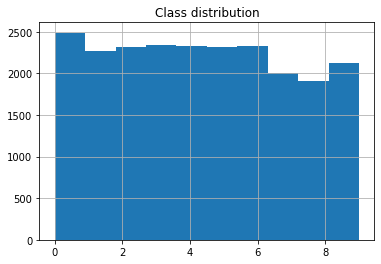

In [7]:
dataset = pd.read_csv('data/driver_imgs_list.csv')
print(dataset.shape)

# Plotting class distribution
dataset['class_type'] = dataset['classname'].str.extract('(\d)',expand=False).astype(np.float)
plt.figure(figsize = (20,20))
dataset.hist('class_type', alpha=1, layout=(1,1), bins=10)
plt.title('Class distribution')
plt.show()

# Creating Model

In [8]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.autograd import Variable
from torch.utils.data import DataLoader
from torch.utils.data import sampler

import torchvision.datasets as dset
import torchvision.transforms as T

import timeit

In [9]:
torch.cuda.is_available()

True

In [10]:
class Flatten(nn.Module):
    def forward(self, x):
        N, C, H, W = x.size() # read in N, C, H, W
        return x.reshape(N, -1)  # "flatten" the C * H * W values into a single vector per image

In [11]:
if torch.cuda.is_available():
    DTYPE = torch.cuda.FloatTensor #GPU type
else:
    DTYPE = torch.FloatTensor #CPU type

In [12]:
model_base = nn.Sequential(
    nn.Conv2d(3, 64, kernel_size=10, stride=1),
    nn.ReLU(inplace=True),
    nn.BatchNorm2d(64),
    nn.MaxPool2d(2, stride=2),
    nn.Dropout(0.5),
    Flatten(),
    nn.Linear(46656,1024),
    nn.ReLU(inplace=True),
    nn.Dropout(0.5),
    nn.Linear(1024, 10),
)

model = model_base.type(DTYPE)

loss_fn = nn.CrossEntropyLoss().type(DTYPE)
optimizer = optim.SGD(model.parameters(), lr = 1e-4, weight_decay = 0.9, momentum=0.8)
#decayRate = 0.96
#optimizer = torch.optim.lr_scheduler.ExponentialLR(optimizer=optimizer, gamma=decayRate) # wrap optimizer in a learning rate decay

# Training model

In [13]:
%autoreload
import time
start_time = time.time()

torch.cuda.random.manual_seed(2468)
model.apply(Helper.reset)
loss_history = Helper.train(model, Xtrain, Ytrain, loss_fn, optimizer, num_epochs=3, dtype = DTYPE)

print("--- %s seconds to train ---" % (time.time() - start_time)) # print the training time

Starting epoch 1 / 3
t = 25, loss = 2.2702
t = 50, loss = 2.1793
t = 75, loss = 2.0563
t = 100, loss = 2.0264
t = 125, loss = 1.9495
t = 150, loss = 1.8033
t = 175, loss = 1.6873
t = 200, loss = 1.6611
t = 225, loss = 1.6469
t = 250, loss = 1.4639
t = 275, loss = 1.4420
t = 300, loss = 1.4626
Starting epoch 2 / 3
t = 25, loss = 1.3335
t = 50, loss = 1.4005
t = 75, loss = 1.1026
t = 100, loss = 1.4746
t = 125, loss = 1.1630
t = 150, loss = 1.1393
t = 175, loss = 1.1037
t = 200, loss = 1.0090
t = 225, loss = 1.0711
t = 250, loss = 1.0226
t = 275, loss = 1.0126
t = 300, loss = 1.1342
Starting epoch 3 / 3
t = 25, loss = 1.1348
t = 50, loss = 1.0520
t = 75, loss = 0.9180
t = 100, loss = 1.1730
t = 125, loss = 0.9012
t = 150, loss = 0.9949
t = 175, loss = 1.0417
t = 200, loss = 0.8735
t = 225, loss = 0.8666
t = 250, loss = 0.9385
t = 275, loss = 0.8391
t = 300, loss = 0.9735
--- 137.18385767936707 seconds to train ---


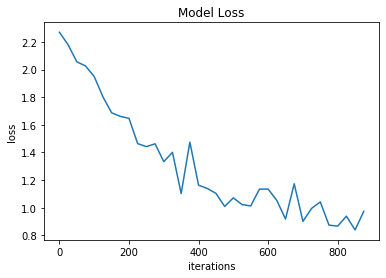

In [14]:
plt.plot(np.arange(0, len(loss_history)*25, 25), loss_history)
plt.title("Model Loss")
plt.xlabel("iterations")
plt.ylabel("loss")
plt.show()

In [15]:
print(min(loss_history))

0.8390520215034485


# Evaluating model

In [16]:
%autoreload

Helper.evaluate(model, Xval, Yval, Xval.shape[0], DTYPE)

Got 6174 / 6700 correct (92.15)


92.14925373134328

In [17]:
#parameter tuning
%autoreload

#results = {}
#best_val = -1
#best_softmax = None
#learning_rates = [1e-7, 5e-7]
#regularization_strengths = [2.5e4, 5e4]



#torch.cuda.random.manual_seed(2468)
#model.apply(Helper.reset)
#loss_history = Helper.train(model, Xtrain, Ytrain, loss_fn, optimizer, num_epochs=3, dtype = DTYPE)

In [18]:
# run on the test set for final accuracy
%autoreload
predictions = Helper.get_predictions(model, Xtest, Xtest.shape[0], DTYPE)

#predictions = Helper.get_predictions(model, Xtest[:101], 101, DTYPE)

In [19]:
print(len(predictions))

79726


In [20]:
%autoreload

#bring in the test_ids (image filenames in test directory)
with open('./test_ids.pkl', 'rb') as fid:
    test_ids = pickle.load(fid)

#setup predictions array for kaggle submission
predictions_matrix = Helper.to_prediction_list(predictions)

In [21]:
print(predictions_matrix[0])

[0. 0. 0. 0. 0. 0. 1. 0. 0. 0.]


In [22]:
# make a kaggle submission
#print(predictions_matrix.shape)
Helper.create_submission(predictions_matrix, test_ids)

# Kaggle will provide the test accuracy result

'kaggle_submissions\\submission_2020-06-12-04-15.csv'

In [23]:
# save the best model to a pickle file
#with open(torch_model.pkl) as fid:
#    pickle.dump(model, fid)